# 7. AMES HOUSING: FEATURE SELECTION
---

In this chapter, we'll explore how to use correlation between features and the target column, correlation between features, and variance of features to select features. We'll specifically focus on selecting from feature columns that don't have any missing values or don't need to be transformed to be useful

## 1. Introducing the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

ames = pd.read_csv('data/Ames_Housing.txt', delimiter="\t")

train, test = train_test_split(ames, test_size=0.2, random_state=42)
print(train.shape, test.shape)

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']

X_test = test.drop('SalePrice', axis=1)
y_test = test['SalePrice']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(2344, 82) (586, 82)


((2344, 81), (2344,), (586, 81), (586,))

## 2. Missing Values

In [7]:
train.dtypes.value_counts()

object     43
int64      28
float64    11
dtype: int64

In [14]:
train_num = train.select_dtypes(include=['int64', 'float64'])
num_drop = ['PID', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 
            'Mo Sold', 'Yr Sold']
train_num = train_num.drop(num_drop, axis=1)
is_null = train_num.isnull().sum()
full_cols = is_null[is_null == 0]
print(len(full_cols))
full_cols.index

23


Index(['Order', 'MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'SalePrice'],
      dtype='object')

## 3. Correlating Features with Target

In [19]:
train_num = train[full_cols.index]
corr_matrix = train_num.corr()
sorted_corrs = corr_matrix['SalePrice'].abs().sort_values()
print(sorted_corrs)

Low Qual Fin SF    0.016
Misc Val           0.018
Order              0.021
3Ssn Porch         0.035
MS SubClass        0.066
Pool Area          0.079
Overall Cond       0.104
Kitchen AbvGr      0.116
Enclosed Porch     0.131
Screen Porch       0.137
Bedroom AbvGr      0.149
Lot Area           0.261
2nd Flr SF         0.279
Half Bath          0.285
Open Porch SF      0.298
Wood Deck SF       0.333
Fireplaces         0.468
TotRms AbvGrd      0.475
Full Bath          0.542
1st Flr SF         0.607
Gr Liv Area        0.698
Overall Qual       0.795
SalePrice          1.000
Name: SalePrice, dtype: float64


## 4. Correlation Matrix Heatmap

<AxesSubplot:>

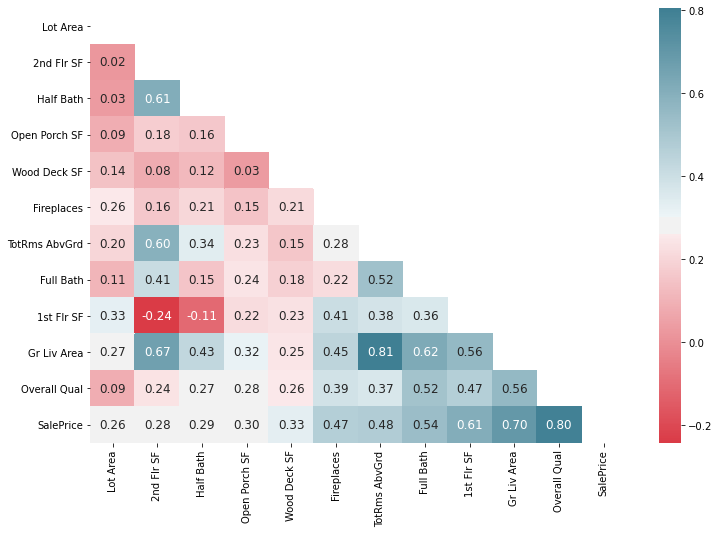

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

strong_corrs = sorted_corrs[sorted_corrs > 0.2]
corr = train_num[strong_corrs.index].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
color = sns.diverging_palette(10, 220, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, mask=mask, cmap=color, annot=True, 
            fmt=".2f", annot_kws={"size": 12})

In [67]:
corr_cols = strong_corrs.drop('TotRms AbvGrd')
corr_cols

Lot Area         0.261
2nd Flr SF       0.279
Half Bath        0.285
Open Porch SF    0.298
Wood Deck SF     0.333
Fireplaces       0.468
Full Bath        0.542
1st Flr SF       0.607
Gr Liv Area      0.698
Overall Qual     0.795
SalePrice        1.000
Name: SalePrice, dtype: float64

We dropped `TotRms AbvGrd` because it is highly correlated with `Gr Liv Area`, which has higher correlation with our target

## 5. Training and Testing the Model

In [73]:
cols = corr_cols.drop(['SalePrice']).index

X_train = train[cols]
y_train = train['SalePrice']

X_test = test[cols]
y_test = test['SalePrice']

print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

X_train.shape, X_test.shape

0
0


((2344, 10), (586, 10))

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_test_pred, y_test)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('RMSE_train:', train_rmse)
print('RMSE_test:', test_rmse, '\n')
print('Mean_SalePrice:', train['SalePrice'].mean())
print('STD_SalePrice:', train['SalePrice'].std())

RMSE_train: 37181.4937785522
RMSE_test: 41347.661853165526 

Mean_SalePrice: 178582.20776450512
STD_SalePrice: 77125.07271273082
